In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as am


Bad key "text.kerning_factor" on line 4 in
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:

label = 'h_0.4_p_0.8_q_0.1'
file = open("data_{}.txt".format(label))

realisations = []
flag = True 
L = 255

n = 0 

while n < 100: 
    line = file.readline() 
    if line[0] == '#':
        flag = True 
        print(line)
    else: 
        if flag:  
            new_realisation = [line]
            realisations.append(new_realisation)
            n += 1 
            flag = False
        else:
            new_realisation.append(line)
            
realisations = realisations[:-1]

#Parameters={ Seed: 5, Branching rate: 0.4, p : 0.8, q : 0.1, Realisations: 100, Chunk size: 100, Dimension: 2, (Max) Lattice size: 255, Graph Type: 0 }

#Version: #4534

# Running for L = 255

# Starting the 0 th realisation 

# Starting the 1 th realisation 

# Starting the 2 th realisation 

# Starting the 3 th realisation 

# Starting the 4 th realisation 

# Starting the 5 th realisation 

# Starting the 6 th realisation 

# Starting the 7 th realisation 

# Starting the 8 th realisation 

# Starting the 9 th realisation 

# Starting the 10 th realisation 

# Starting the 11 th realisation 

# Starting the 12 th realisation 

# Starting the 13 th realisation 

# Starting the 14 th realisation 

# Starting the 15 th realisation 

# Starting the 16 th realisation 

# Starting the 17 th realisation 

# Starting the 18 th realisation 

# Starting the 19 th realisation 

# Starting the 20 th realisation 

# Starting the 21 th realisation 

# Starting the 22 th realisation 

# Starting 

In [3]:
def extract_evolution(realisation): 
    tracers = []
    active_particles = [] 
    edges = [] 
    msds = [] 
    counts = [] 
    passive_flag = False 
    active_flag = False
    for line in realisation:  
        if line.startswith('count'):
            counts.append(float(line[6:-1]))
        if line.startswith('passive'):
            passive_indices = np.fromstring(line[8:-1], sep=',')
            passive_indices = np.unravel_index(passive_indices.astype('int'), (L, L))
            passive_flag = True 
        elif line.startswith('active'):
            active_indices = np.fromstring(line[7:-1], sep=',')
            active_indices = np.unravel_index(active_indices.astype('int'), (L, L))
            active_flag = True 
        elif line.startswith('msd'):
            msds.append(float(line[4:-1]))
        elif line.startswith('edge'): 
            edges.append(np.fromstring(line[5:-1], sep=','))
        else: 
            tracer_snapshot = np.zeros((L, L)) # clear the snapshot for the next time slice 
            active_snapshot = np.zeros((L, L)) 
            
        if passive_flag and active_flag: 
            tracer_snapshot[passive_indices] = 1 # set occupied sites to -1 
            
            for (i,j) in zip(*active_indices):
                active_snapshot[i, j] += 1 
            tracers.append(tracer_snapshot)
            active_particles.append(active_snapshot)
            passive_flag = False 
            active_flag = False 
            
    return np.array(edges), np.array(msds), np.array(counts), np.array(tracers), np.array(active_particles)

def calculate_moments_of_snapshot(tracers): 
    x, y = np.indices((L, L))
    centre = L/2
    x = x - L/2
    y = y - L/2 
    dist = np.sqrt(x**2 + y**2)
    N = np.sum(tracers)
    m1 = np.sum(tracers*dist)/N
    m2 = np.sum(tracers*dist**2)/N
    m3 = np.sum(tracers*dist**3)/N
    m4 = np.sum(tracers*dist**4)/N
    return m1, m2, m3, m4
    

def calculate_moments(actives): 
    x, y = np.indices((L, L))
    centre = L/2
    x = x - L/2
    y = y - L/2 
    dist = np.expand_dims(np.sqrt(x**2 + y**2),axis=0)
    N = np.sum(actives, axis=(1, 2))
    m1 = get_nth_moment(actives, dist, N, 1)
    m2 = get_nth_moment(actives, dist, N, 2)
    m3 = get_nth_moment(actives, dist, N, 3)
    m4 = get_nth_moment(actives, dist, N, 4)
    return m1, m2, m3, m4

def get_nth_moment(evolution, dist, N, n):
    m = np.sum(evolution*dist**n, axis=(1, 2))
    m[N>0] = m[N>0]/N[N>0]
    return m 

def make_movies(evolution, label):
    fig = plt.figure(figsize=(20, 20))
    ims = []
    plt.axis('off')
    for xy in evolution:
        im = plt.imshow(xy, animated=True, vmin=0, vmax=2, cmap='Blues', origin='lower') 
        plt.axis('off')
        ims.append([im])
        
    ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    mywriter = am.FFMpegWriter()
    ani.save("{}_movie_{}.mp4".format(label, i), writer=mywriter)
    plt.close()  
    
        

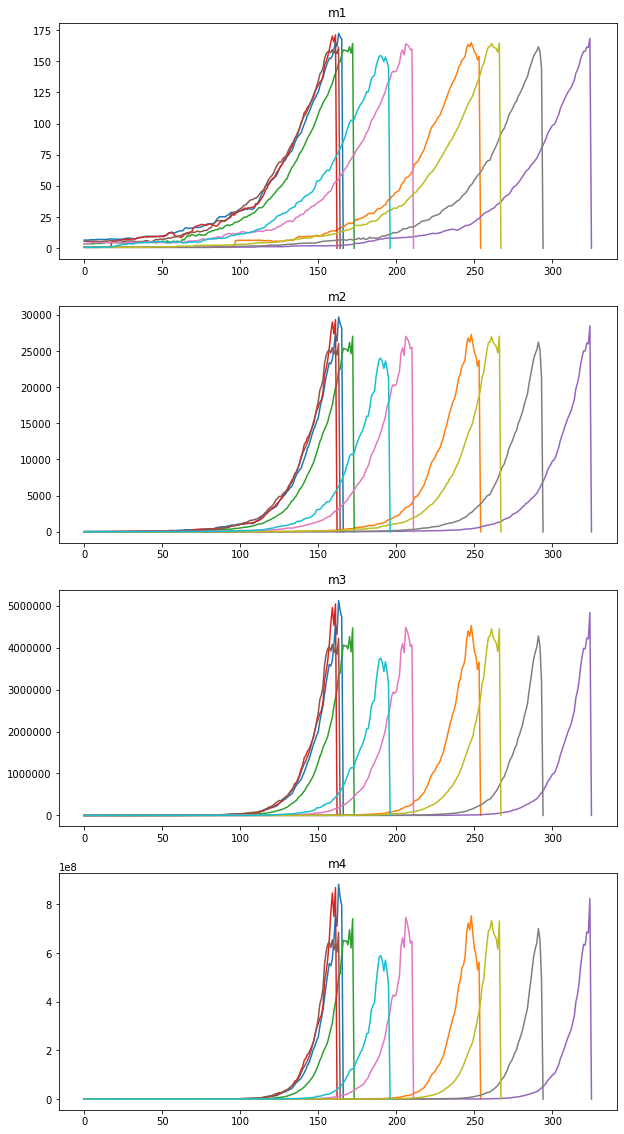

In [11]:

 _, axes = plt.subplots(4, figsize=(10, 20))

active_ensemble = [] 
tracer_moments = [] 
for (i, realisation) in enumerate(realisations[:10]):
    _, msds, counts, tracers, actives = extract_evolution(realisation) 
    active_ensemble.append(np.sum(actives, axis=(1, 2)))
    m1, m2, m3, m4 = calculate_moments(actives)
    axes[0].plot(m1)
    axes[1].plot(m2)
    axes[2].plot(m3)
    axes[3].plot(m4) 
    
    tracer_moments.append(calculate_moments_of_snapshot(tracers))    
    
axes[0].set_title('m1')
axes[1].set_title('m2')
axes[2].set_title('m3')
axes[3].set_title('m4')

plt.show()

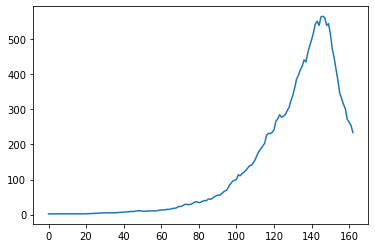

In [26]:
# Plot active particles numbers average over the ensemble 

tmin = 10e4 # just some large number
for i in active_ensemble: 
    tmin = min(len(i), tmin)

active_ensemble_array = np.vstack([i[:tmin] for i in active_ensemble])
plt.plot(np.mean(active_ensemble_array, axis=0))
plt.show() 


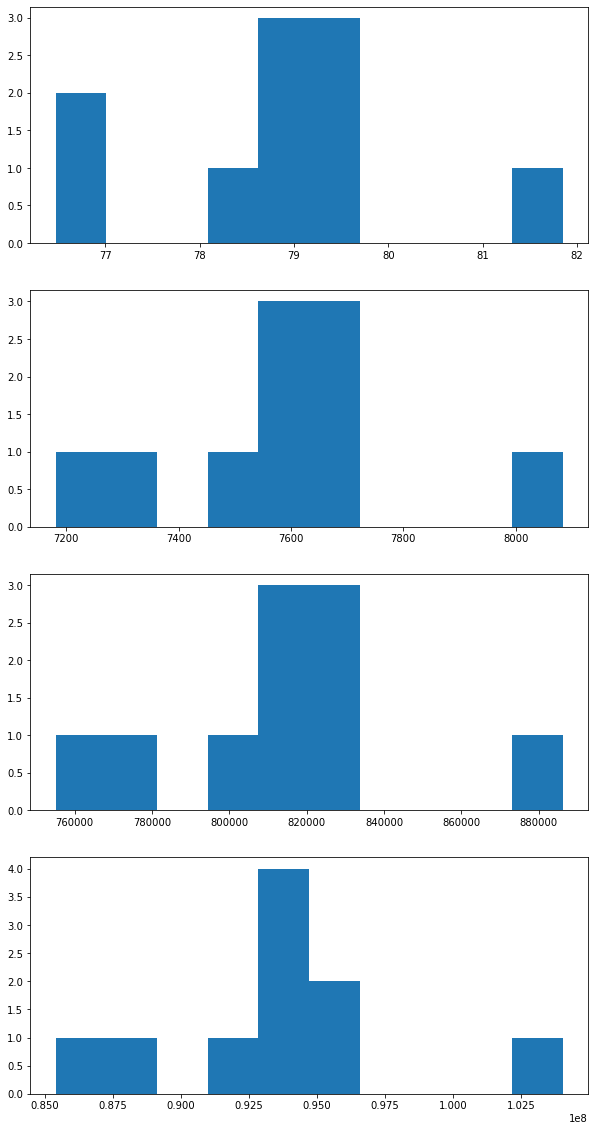

In [31]:
# Plot histogram of the moments of the final tracer distribution 

tracer_moments = np.array(tracer_moments)

_, axes = plt.subplots(4, figsize=(10, 20))
for i in range(4):
    axes[i].hist(tracer_moments[:, i])
    
plt.show() 